# Notes on Ensemble Methods for ML


## Voting Classifiers



*    A way to biuld better classifiers by aggregating the predictions of each classifier and predict the class that get most votes. This is a *Hard Voting Classifer*.







*   Even if each classifier is a *weak learner*, the ensemble ca stil be a *strong learner*, i.e. achieving higher accuracy, provided there is a big enough number of weak learners and they are sufficiently diverse. 
*   This is due to the **Law of Large Numbers**



* **Note**: Ensemble Methods work best when predictors are as **independent** and **diverse** from one another as possible. One way to achieve this is to train classifiers using very different algorithms, increasing thus the chance to make different kind of errors and to improve ensemble accuracy.

## Data Set

We'll use the *Moon* dataset:

In [6]:
from sklearn.datasets import make_moons

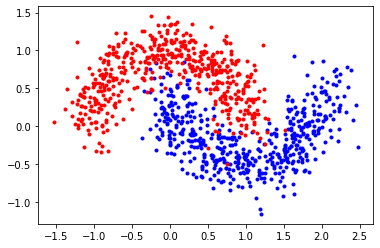

In [8]:
import matplotlib.pyplot as plt

X, y = make_moons(n_samples=1000, noise=0.2)

plt.plot(X[:,0][(y==1)],X[:,1][(y==1)],'b.')
plt.plot(X[:,0][(y==0)],X[:,1][(y==0)],'r.')
plt.show()

We'll do the train/test split:

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Now, we'll build the *Hard Voting Classifier*.

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [5]:
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

In [14]:
voting_clf = VotingClassifier(
    estimators = [('lr',log_clf),('rf',rnd_clf),('svc',svm_clf)],
    voting = 'hard')
voting_clf.fit(X_train,y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                             

We compare each classifier:

In [16]:
from sklearn.metrics import accuracy_score

for clf in (log_clf,rnd_clf,svm_clf,voting_clf):
  clf.fit(X_train,y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__,accuracy_score(y_test,y_pred))


LogisticRegression 0.845
RandomForestClassifier 0.935
SVC 0.955
VotingClassifier 0.95


## Bagging

* Another approach is to **use the same training algorithm for every predictor and train on different random subsets of the training set**
* When the sampling is performed with repacement, the method is called **bagging** (i.e. boostrap aggregating). Bagging the allows training instances to be sampled several times for the same predictor.
* When the sampling is performed without replacement, it is called **pasting.**

* Once the predictors are trained, the ensemble makes a prediction for a new instance by aggregating the predictions on all predictors. 
* The aggregating function is called **statistical mode** (i.e. the most frequent prediction, just like in a hard-vote classifier) for classification, or **average** for regression.

* Each individual predictor has a higher bias than if where trained on the original training set, but **aggregation reduces both bias and variance**.

* Generally, **the ensemble has similar bias but lower variance** than a single predictor trained on the original training set.

In [17]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

We train 500 Decision Tree Classifiers, each trained on 100 training instances randomly sampled fro the training set with replacement (bootstrap = True). The n_jobs parameter tells scikit_learn the number of CPU cores to use (-1 for all available cores.)

In [21]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),n_estimators=500, ## 500 tree classifiers
    max_samples=100,bootstrap=True,n_jobs=-1 ## 100 random instances. bootstrap = True: bagging. Otherwise: pasting
)

In [22]:
bag_clf.fit(X_train,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=None,


In [23]:
y_pred_train = bag_clf.predict(X_train)
accuracy_score(y_train,y_pred_train)

0.9675

**Note**: The ensemble will generalize better than a single tree. **The ensemble has a comprable bias but smaller variance** (it makes roughly the same number of errors on the training set, but the decision boundary is less irregular.)

**Bagging vs. Pasting**: Bootstraing introduces more diversity in the subsets that each predictor is trained on, so bagging has usually slightly higher bias than pasting, but less variance (the extra diversity means that predictors are less correlated).

## Out-of-Bag Evaluation

* By default, a Bagging Classifier samples *m* training instances with replacement, where *m* is the size of the training set. This means that only around 63% of the training instances are sampled on average for each predictor. Note that they are not the same 37% for all predictors.  

* The remaining 37% training instances that are not sampled are called **out-of-bag** (oob) instances. 
* Since a predictor never sees the oob instances, they can be used for validation. 

In [34]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500, 
    bootstrap=True,n_jobs=-1,
    oob_score = True,
    max_samples = 100
)

In [35]:
bag_clf.fit(X_train,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=None,


In [36]:
y_pred_train = bag_clf.predict(X_train)
accuracy_score(y_train,y_pred_train)

0.96625

In [37]:
bag_clf.oob_score_
# We should get close to this accuracy on the testing set.  

0.9625

In [38]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test,y_pred)
# Close enough

0.955

The oob decision function is available. We will get the class probabilities for each instance:

In [39]:
bag_clf.oob_decision_function_

array([[0.02921348, 0.97078652],
       [0.99771167, 0.00228833],
       [0.76267281, 0.23732719],
       ...,
       [0.98177677, 0.01822323],
       [0.98657718, 0.01342282],
       [0.01382488, 0.98617512]])

So, the first instace has a 3% probability of belonging to the negative class, and a 97% of belonging to the positive class.

##  Random Forests

A Random Forest Classifier is an ensemble of Decision Trees, usually trained using the bagging method, typically with max_samples set to the size of the training set. 

In [40]:
from sklearn.ensemble import RandomForestClassifier

In [42]:
rnd_clf = RandomForestClassifier(n_estimators=500, # 500 trees
                                 max_leaf_nodes = 16, # Each tree is limited to 16 nodes
                                 n_jobs = -1)

In [43]:
rnd_clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=16, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [46]:
y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.94

* The Random Forest algorithm results in greater tree diversity, which trades a higher bias for a lowe variance, giving an overall better model. 

The following Bagging Classifier is roughly equivalent:

In [47]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(splitter= 'random',max_leaf_nodes=16),
                            n_estimators = 500, max_samples = 1.0, bootstrap = True,n_jobs = -1)

In [48]:
bag_clf.fit(X_train,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=16,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=None,
  

In [49]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.945

## Boosting

* The main idea is to **train predictors sequentially, each trying to correct its predecessor**. 

### AdaBoost

* **AdaBoost** has each new predictor focusing on correcting its predecessor by pay attention on the training instances that the predecessor underfitted. This results in new predictors focusing more and more on the hard cases. 

* The algorithm first trains a base classifier and uses it to make predictions on the training set. The algorithm then increases the relative weight of miscalssified training instances. Then it trains a second classifier, using the updated weights, and again makes predictions on the training set, updated the weights, and so on. 

* Onde all predictors are trained, the ensemble makes predictions very much like bagging, except that predictors have different weights depending on their overall accuracy on the weighted trained set. 

In [50]:
from sklearn.ensemble import AdaBoostClassifier

In [51]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),n_estimators=200,
                             algorithm = 'SAMME.R', learning_rate = 0.5)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [52]:
y_pred = ada_clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.925

### Gradient Boosting

* This algorith also works sequentially adding predictors, each one correcting its predecessor. However, instead of tweaking the instance weights at every iteration, this method tries to fit the new predictor to the **residual errors** made by the previous predictors.

We do a simple example on this, using Decision Trees as base predictors and a noisy quadratic  training set:

#### Noisy Quadratic Dataset

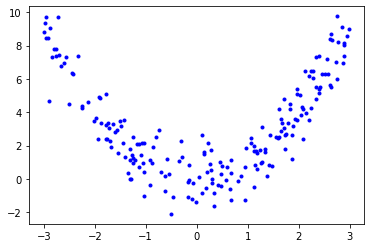

In [54]:
import numpy as np

m=200
X = 6 * np.random.rand(m,1) - 3
y = X**2 + np.random.randn(m,1)

plt.plot(X,y,'b.')
plt.show()

#### Basic Illustration

In [55]:
from sklearn.tree import DecisionTreeRegressor

In [56]:
tree_reg1 = DecisionTreeRegressor(max_depth = 2)
tree_reg1.fit(X,y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

We now train a second regressor on the residual errors made by the first predictor:

In [57]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X,y2)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [58]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X,y3)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [64]:
X_new = 6 * np.random.rand(m,1) - 3
y_new = X_new**2 + np.random.randn(m,1)
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

#### Example

In [68]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

In [67]:
X_train, X_val, y_train, y_val = train_test_split(X,y)

* The Regressor has a learning rate hyperparamter. If one sets it to a low value, you will need more trees in the ensemble to fit the training set, but the predictions wil be better. **This is a regularization techinique calle Shrinkage.**
* In order to find the optimal number of trees, one can used the staged_predict method: it returns an iterator over the predictions made by the ensemble at each stage of the training. We start with 120 trees.
* This is an example of **Early Stopping**.



In [69]:
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=120,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

We now get the error for each stage:

In [76]:
errors = [mean_squared_error(y_val,y_pred) for y_pred in gbrt.staged_predict(X_val)]
best_n_estimators = np.argmin(errors) + 1

And this will Regressor will have the lowest error:

In [77]:
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=best_n_estimators)
gbrt_best.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=36,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

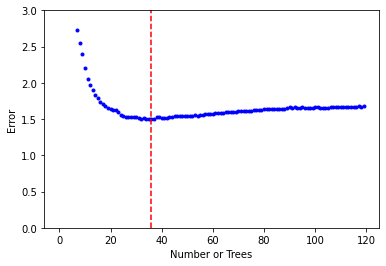

In [79]:
plt.plot(errors,'b.')
plt.ylim([0,3])
plt.axvline(best_n_estimators,color = 'r',ls = '--')
plt.xlabel('Number or Trees')
plt.ylabel('Error')
plt.show()

The best regressor has 36 trees:

In [80]:
best_n_estimators

36

How does the prediction looks?

In [82]:
y_pred_train = gbrt_best.predict(X_train)

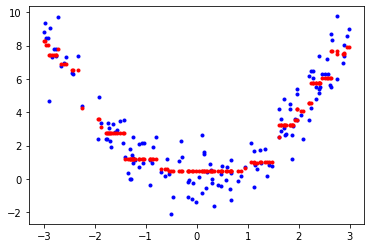

In [83]:
plt.plot(X_train,y_train,'b.')
plt.plot(X_train,y_pred_train,'r.')
plt.show()

So the model generalizes well.

### XGBoost

In [84]:
import xgboost

In [88]:
xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train,y_train)
y_pred = xgb_reg.predict(X_train)

[06:35:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


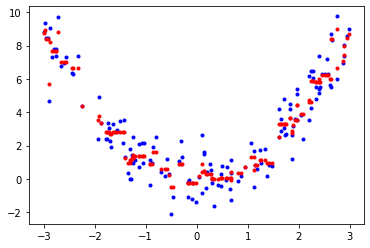

In [89]:
plt.plot(X_train,y_train,'b.')
plt.plot(X_train,y_pred,'r.')
plt.show()

* XGBoost also handles automatically of early stopping

In [91]:
xgb_reg.fit(X_train,y_train,
            eval_set = [(X_val,y_val)],early_stopping_rounds = 2)
y_pred = xgb_reg.predict(X_val)

[06:38:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:3.64958
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:3.38889
[2]	validation_0-rmse:3.15685
[3]	validation_0-rmse:2.93402
[4]	validation_0-rmse:2.73569
[5]	validation_0-rmse:2.57379
[6]	validation_0-rmse:2.4059
[7]	validation_0-rmse:2.26403
[8]	validation_0-rmse:2.13713
[9]	validation_0-rmse:2.01954
[10]	validation_0-rmse:1.91902
[11]	validation_0-rmse:1.83565
[12]	validation_0-rmse:1.74769
[13]	validation_0-rmse:1.67422
[14]	validation_0-rmse:1.62149
[15]	validation_0-rmse:1.56743
[16]	validation_0-rmse:1.51688
[17]	validation_0-rmse:1.47908
[18]	validation_0-rmse:1.45002
[19]	validation_0-rmse:1.42261
[20]	validation_0-rmse:1.39204
[21]	validation_0-rmse:1.37232
[22]	validation_0-rmse:1.35318
[23]	validation_0-rmse:1.33872
[24]	validation_0-rmse:1.32695
[25]	validation_0-rmse:1.31628
[26]	validatio

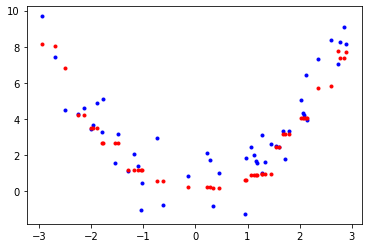

In [92]:
plt.plot(X_val,y_val,'b.')
plt.plot(X_val,y_pred,'r.')
plt.show()